## Gradients in torch recap

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Simple derivative:
### Let's define a random function

In [2]:
def f(x):
  return 3*x**2 - 2*x + 1

In [3]:
f(3.0)

22.0

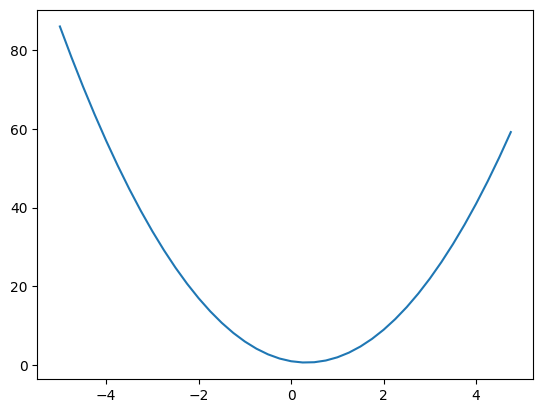

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

##### What is the derivative of this function ?
##### Recall high scholl calculus or https://en.wikipedia.org/wiki/Derivative

Derivatives represent the rate of change or slope of a function at a particular point. They are used extensively in machine learning, deep learning, and optimization problems to optimize the parameters of a model. In simple terms, the derivative of a function tells us how much the output of the function changes with respect to its input.

The derivative of a function f(x) at a point x is defined as the limit of the difference quotient as h approaches zero:

$$f'(x) = \lim_{h\to0} \frac{f(x+h)-f(x)}{h}$$

We can approximate the derivative of a function at a point x by choosing a small value of h and calculating the difference quotient. This approximation becomes more accurate as we decrease the value of h. In PyTorch, we can use the torch.autograd package to calculate the derivatives of a function automatically.

In [5]:
h=0.001
x=3.0
deriv = (f(x+h) - f(x))/h # Numerical aproximation of the slope
print("Slope or derivative",deriv)

Slope or derivative 16.00300000000132


##### What does derivative of 0 means ?
##### A: Basically the slope is 0

### Multi variable derivatives (We don't have just x but rather x,y,z variables)

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
#Let's look at a negative slope

In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h # Where we add a bit a.k.a derivate
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
# What did we change ? 
# A : The variable in respect to which we compute the derivative

### Here is how pytorch computes the slopes/aka "gradients"

In [11]:
import torch

# Define a function
def f(x):
    return x**2 + 2*x + 1

# Define an input tensor
x = torch.tensor([2.0], requires_grad=True)

# Evaluate the function
y = f(x)

# Calculate the derivative of the function with respect to x
y.backward()

print(y)

# Print the derivative
print(x.grad)

tensor([9.], grad_fn=<AddBackward0>)
tensor([6.])


In [12]:
### Let's dive deeeper how the autograd function works

In [13]:

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

In [14]:
a = Value(2.0)
b = Value(-3.0)

In [15]:
a

Value(data=2.0)

In [16]:
b

Value(data=-3.0)

In [17]:
# We want to make make an adition of values 

In [18]:
a+b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [ ]:
# As such we must modifiy the class

In [19]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out


In [20]:
a = Value(2.0)
b = Value(-3.0)
c= Value(10.0)
a+b


Value(data=-1.0)

In [65]:
d= a*b + c

In [21]:
# Code to vizualize the connections between operations

In [22]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)  # We added this to remember the previous operation
        self._op = _op # We added this so the drawing works
        self.label = label
        self.grad = 0.0
 
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [23]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

In [24]:
d = a * b + c

In [25]:
a

Value(data=2.0)

In [26]:
d

Value(data=4.0)

In [78]:
#!conda install -c anaconda graphviz -y

In [79]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


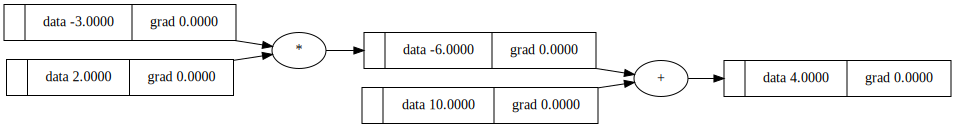

In [80]:
draw_dot(d)

In [82]:
# Add labels

In [81]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

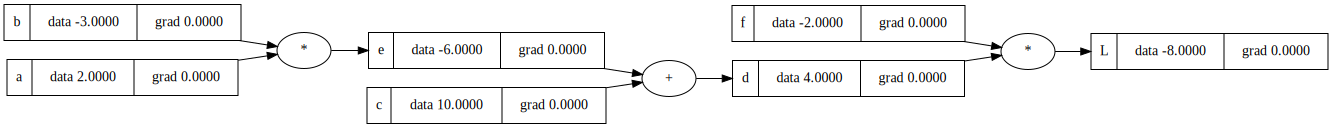

In [83]:
draw_dot(L)

In [84]:
# This can be seen as seen as the forward pass


In [85]:
# Now let's add the back propagation

In [ ]:
#To do that we will compute the derivative of L in respect to L , L in respect to c, L in respect to e and so forth

In [96]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    def __substract__(self, other):
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

In [106]:
def stage_variables():
    h=0.0001
    
    a = Value(2.0 + h, label='a') # The derivative in respect to a
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L1 = d * f; L.label = 'L'
    L1=L1.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L2 = d * f; L.label = 'L'
    L2=L2.data
    
    print((L2 - L1)/h) #The derivative
stage_variables()

-6.000000000021544


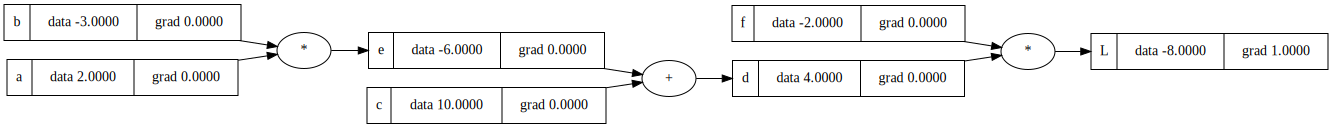

In [107]:
L.grad= 1.0 # the derivative in respect to itself is 1
draw_dot(L)

In [104]:
# dL/dd = ? (What is the derivative of L in respect to d
# (f(x+h) -f(x))/h
# ((d+h)*f -d*f)/h
# (d*f +h*f -d*f) /h
# (h*f)/h
# f

-3.9999999999995595


In [109]:
d.grad = -2

In [110]:
f.grad = 4.0

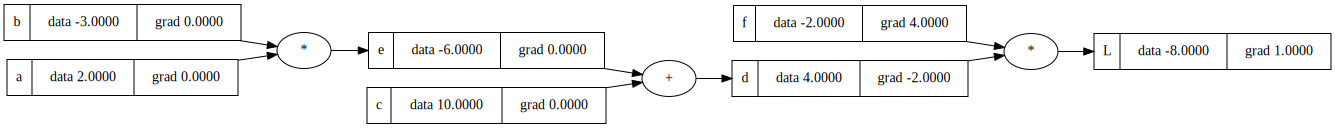

In [111]:
draw_dot(L)

In [115]:
# Compute derdef stage_variables():
def stage_variables():
    
    h=0.0001
    
    a = Value(2.0, label='a') 
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L1 = d * f; L.label = 'L'
    L1=L1.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data +=h  # derivative in respect to d
    f = Value(-2.0, label='f')
    L2 = d * f; L.label = 'L'
    L2=L2.data
    
    print((L2 - L1)/h) #The derivative
stage_variables()

-1.9999999999953388


In [ ]:
# Wow it's actually -2  .. incredible :|

In [116]:
# Ok next questions is at the core of backpropagation
# how do we derive l in respect to c dl/dc ?

In [117]:
#dd/dc

#d = c + e 

#f(x+h) - f(x))/h(

#((c+h+e) - (c+e))/h

# h/h =1

# dd/dc=dd/de=1

In [118]:
# So basically the plus node only knows the local influences of the local derivatives
# Hence we use the chain rule in calculus : (https://en.wikipedia.org/wiki/Chain_rule)
# Can be extremely confusing but basically: if a car travels twice as fast as a bicycle and the bicycle is four times as fast as walking then the care is 2x4=8 as fast as walking
# Basically the chain rule says: multiply previous gradients
# I know I know : calculus seems easy (This is just the surface)

In [ ]:
#Hence, dL/dc = dL/dd* dd/dc (Chain Rule)
## Known
#dL/dd=-2
#dd/dc=1

#Finally : dL/dc = -2

In [119]:
c.grad=-2

In [120]:
# We can verify this with the mathematical formula

In [122]:
# Compute derdef stage_variables():
def stage_variables():
    
    h=0.0001
    
    a = Value(2.0, label='a') 
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L1 = d * f; L.label = 'L'
    L1=L1.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data +=h # Derivative in respect to h
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L2 = d * f; L.label = 'L'
    L2=L2.data
    
    print((L2 - L1)/h) #The derivative
stage_variables()

-1.9999999999953388


In [ ]:
# Vuala

In [ ]:
# Rinse and repeat and you computed the whole gradients

In [ ]:
# Gradients represent the rate of change

In [ ]:
# Substracting the gradients from the W matrix gives as a nn with a lower loss

In [ ]:
# This is the magic sauce behind everything deep learning

In [ ]:
# If you got this far you are awesome